<a href="https://colab.research.google.com/github/othrou/Online-Learning/blob/main/Active%20Learning%20Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> **📌 ACTIVE LEARNING** </font></center></h1>
<h3><center> ROUGUI Othmane</center></h3>
<br>

Active learning is a semi-supervised machine learning technique where the model iteratively selects the most informative samples from an unlabeled pool to query their labels. The goal is to improve the model's performance with minimal labeled data. By strategically selecting which samples to label, active learning reduces the need for large labeled datasets, making it particularly useful in scenarios where labeling is expensive or time-consuming.

---

## **📚 Table of Contents**

1. [**Dataset Preparation**](#task-1-dataset-preparation)  
   - Load the Iris dataset.  
   - Split into labeled set, unlabeled pool, and test data.  

2. [**Uncertainty Sampling Implementation**](#task-2-implement-uncertainty-sampling)  
   - Implement the Uncertainty Sampling algorithm.  
   - Run using Logistic Regression.  
   - Analyze accuracy progression over queries.  

3. [**Query by Committee (QBC) Implementation**](#task-3-implement-query-by-committee-qbc)  
   - Implement the QBC algorithm.  
   - Use a committee of models (e.g., Random Forest, SVM, Logistic Regression).  
   - Analyze accuracy progression over queries.  

4. [**Analysis & Questions**](#analysis--questions)  
   - Compare Uncertainty Sampling and QBC.  
   - Evaluate accuracy improvements, query efficiency, and model stability.  

---



In [4]:
import torch

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import numpy as np
from random import shuffle

In [51]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [16]:
X.dtype, X.shape

(dtype('float64'), (150, 4))

In [52]:
# Define the proportions for splitting
test_size = 0.3
unlabeled_size = 0.5
labeled_size = 1 - test_size - unlabeled_size

# Step 2.1: Split into training (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# Step 2.2: Split training data into labeled (20%) and unlabeled (50%)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X_train, y_train, test_size=unlabeled_size / (unlabeled_size + labeled_size), random_state=42, stratify=y_train
)

# Print the sizes of each split
print(f"Labeled set (L): {X_labeled.shape[0]} samples")
print(f"Unlabeled pool (U): {X_unlabeled.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Labeled set (L): 30 samples
Unlabeled pool (U): 75 samples
Test set: 45 samples


In [46]:
# Step 5: Print the sizes of each split
print(f"Labeled set (L): {X_labeled.shape[0]} samples")
print(f"Unlabeled pool (U): {X_unlabeled.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Step 6: Verify class distribution in each split
def print_class_distribution(y, split_name):
    unique_classes, counts = np.unique(y, return_counts=True)
    print(f"Class distribution in {split_name}:")
    for cls, count in zip(unique_classes, counts):
        print(f"  Class {cls}: {count} samples")

print_class_distribution(y_labeled, "Labeled set (L)")
print_class_distribution(y_unlabeled, "Unlabeled pool (U)")
print_class_distribution(y_test, "Test set")

Labeled set (L): 30 samples
Unlabeled pool (U): 75 samples
Test set: 45 samples
Class distribution in Labeled set (L):
  Class 0: 10 samples
  Class 1: 10 samples
  Class 2: 10 samples
Class distribution in Unlabeled pool (U):
  Class 0: 25 samples
  Class 1: 25 samples
  Class 2: 25 samples
Class distribution in Test set:
  Class 0: 15 samples
  Class 1: 15 samples
  Class 2: 15 samples


In [47]:
def uncertainty(method='entropy', prob_dist=None):
    if method == 'entropy':
        # Entropy-based uncertainty
        uncertainties = -np.sum(prob_dist * np.log(prob_dist + 1e-10), axis=1)

    elif method == 'Least Confident':
        # Least confident uncertainty
        uncertainties = 1 - np.max(prob_dist, axis=1)

    elif method == 'margin':
        # Margin-based uncertainty (difference between top two probabilities)
        sorted_probs = np.sort(prob_dist, axis=1)
        uncertainties = sorted_probs[:, -1] - sorted_probs[:, -2]

    return uncertainties

In [41]:
def Active_Learning_uncertainty_sampling(
    X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test,
    model=None, budget=None, method='entropy'
):
    # Initialize the model if not provided
    if model is None:
        model = LogisticRegression(max_iter=1000, random_state=42)

    # Initial training on the labeled set
    model.fit(X_labeled, y_labeled)

    # Set budget if not provided
    if budget is None:
        budget = len(X_unlabeled) // 2

    # List to store accuracy history
    accuracy_history = []

    # Active learning loop
    for i in range(budget):
        # Step 4: Compute probabilities P_M(y|x) for all x in U
        probas = model.predict_proba(X_unlabeled)

        # Step 5: Compute uncertainty using the specified method
        uncertainties = uncertainty(method=method, prob_dist=probas)

        # Step 6: Select the instance with the highest uncertainty
        query_idx = np.argmax(uncertainties)
        query_instance = X_unlabeled[query_idx]
        query_label = y_unlabeled[query_idx]

        # Step 7: Add the queried instance to the labeled set
        X_labeled = np.vstack([X_labeled, query_instance])
        y_labeled = np.append(y_labeled, query_label)

        # Step 8: Remove the queried instance from the unlabeled pool
        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_idx)

        # Step 9: Retrain the model on the updated labeled set
        model.fit(X_labeled, y_labeled)

        # Evaluate the model on the test set
        test_accuracy = accuracy_score(y_test, model.predict(X_test))
        accuracy_history.append(test_accuracy)

        # Print progress
        print(f"Iteration {i+1}/{budget}: Test Accuracy = {test_accuracy:.4f}")

    # Final test accuracy
    final_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"Final Test Accuracy: {final_accuracy:.4f}")

    return accuracy_history

Iteration 1/37: Test Accuracy = 0.8889
Iteration 2/37: Test Accuracy = 0.8889
Iteration 3/37: Test Accuracy = 0.9333
Iteration 4/37: Test Accuracy = 0.9111
Iteration 5/37: Test Accuracy = 0.9333
Iteration 6/37: Test Accuracy = 0.9333
Iteration 7/37: Test Accuracy = 0.9333
Iteration 8/37: Test Accuracy = 0.9333
Iteration 9/37: Test Accuracy = 0.9556
Iteration 10/37: Test Accuracy = 0.9333
Iteration 11/37: Test Accuracy = 0.9333
Iteration 12/37: Test Accuracy = 0.9333
Iteration 13/37: Test Accuracy = 0.9333
Iteration 14/37: Test Accuracy = 0.9556
Iteration 15/37: Test Accuracy = 0.9333
Iteration 16/37: Test Accuracy = 0.9333
Iteration 17/37: Test Accuracy = 0.9333
Iteration 18/37: Test Accuracy = 0.9333
Iteration 19/37: Test Accuracy = 0.9333
Iteration 20/37: Test Accuracy = 0.9556
Iteration 21/37: Test Accuracy = 0.9333
Iteration 22/37: Test Accuracy = 0.9333
Iteration 23/37: Test Accuracy = 0.9556
Iteration 24/37: Test Accuracy = 0.9333
Iteration 25/37: Test Accuracy = 0.9333
Iteration

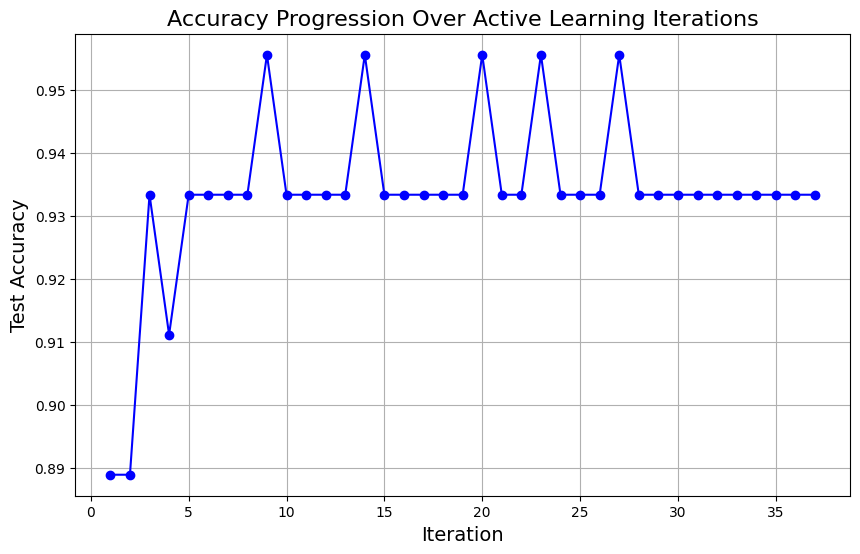

In [48]:
import matplotlib.pyplot as plt

# Run active learning
accuracy_history = Active_Learning_uncertainty_sampling(
    X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test,
    method='entropy'
)

# Plot accuracy progression
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-', color='b')
plt.title('Accuracy Progression Over Active Learning Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.grid(True)
plt.show()

## Active Learning Accuracy Progression Analysis

The plot illustrates the progression of test accuracy over active learning iterations.

### Analysis

1. **Initial Performance (Iterations 0-5)**:
   - The model starts with a relatively low test accuracy (~0.89) at iteration 0.
   - There is a raise in accuracy to around 0.91 at iteration 2, which might indicate that the initial queried samples were representative

2. **Fluctuations (Iterations 5-25)**:
   - The test accuracy exhibits fluctuations, with peaks and troughs. For example:
     - At iteration 10, the accuracy spikes to approximately 0.96.
     - At iteration 15, there is another peak, followed by a dip.
   - These fluctuations suggest that the uncertainty sampling strategy (used to select the most informative samples) may occasionally query instances that do not significantly improve the model or even degrade its performance.

3. **Stabilization (Iterations 25-35)**:
   - After around iteration 25, the test accuracy stabilizes around 0.93.
   - The fluctuations become smaller, indicating that the model has converged to a reasonably good performance level.
   - This stabilization suggests that the most informative samples have been queried, and further queries are less likely to provide substantial improvements.


### **Interpretation**


**Role of Initial Labeled Set**:
   - The initial low accuracy (~0.89) suggests that the initial labeled set might have been small or not representative of the entire dataset.
   - As more samples are queried and added to the labeled set, the model's performance improves.




# Part 2 : Query By Committee (QBC)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


def Active_Learning_qbc(
    X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test,
    models=None, budget=None
):

    # Set budget if not provided
    if budget is None:
        budget = len(X_unlabeled) // 2

    # Initialize the models if not provided
    if models is None:
        models = [
            LogisticRegression(max_iter=1000, random_state=42),
            RandomForestClassifier(n_estimators=100, random_state=42),
            SVC(probability=True, random_state=42)
        ]

    # Step 1: Train each model in the committee on the initial labeled set
    for model in models:
        model.fit(X_labeled, y_labeled)

    # List to store accuracy history
    accuracy_history = []

    # Active learning loop
    for i in range(budget):
        print(f"Iteration {i+1}/{budget}")

        # Step 2: Collect predictions from all models for the unlabeled pool
        predictions = []
        for model in models:
            predictions.append(model.predict_proba(X_unlabeled))

        # Convert predictions to a numpy array: shape (n_models, n_samples, n_classes)
        predictions = np.array(predictions)

        # Step 3: Compute the vote distribution for each sample
        # Average the probabilities across all models
        avg_probabilities = np.mean(predictions, axis=0)

        # Step 4: Compute the entropy of the vote distribution for each sample
        # Entropy = -sum(p * log(p)) for each sample
        uncertainties = -np.sum(avg_probabilities * np.log(avg_probabilities + 1e-10), axis=1)

        # Step 5: Select the instance with the highest uncertainty
        query_idx = np.argmax(uncertainties)
        query_instance = X_unlabeled[query_idx]
        query_label = y_unlabeled[query_idx]

        # Step 6: Add the queried instance to the labeled set
        X_labeled = np.vstack([X_labeled, query_instance])
        y_labeled = np.append(y_labeled, query_label)

        # Step 7: Remove the queried instance from the unlabeled pool
        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_idx)

        # Step 8: Retrain all models in the committee on the updated labeled set
        for model in models:
            model.fit(X_labeled, y_labeled)

        # Step 9: Evaluate the model on the test set
        # Use the first model as a representative for evaluation (or average predictions)
        test_accuracy = accuracy_score(y_test, models[0].predict(X_test))
        accuracy_history.append(test_accuracy)

        # Print progress
        print(f"Iteration {i+1}/{budget}: Test Accuracy = {test_accuracy:.4f}")

    # Final test accuracy
    final_accuracy = accuracy_score(y_test, models[0].predict(X_test))
    print(f"Final Test Accuracy: {final_accuracy:.4f}")

    return accuracy_history

Iteration 1/37
Iteration 1/37: Test Accuracy = 0.9111
Iteration 2/37
Iteration 2/37: Test Accuracy = 0.9333
Iteration 3/37
Iteration 3/37: Test Accuracy = 0.9556
Iteration 4/37
Iteration 4/37: Test Accuracy = 0.9333
Iteration 5/37
Iteration 5/37: Test Accuracy = 0.9333
Iteration 6/37
Iteration 6/37: Test Accuracy = 0.9333
Iteration 7/37
Iteration 7/37: Test Accuracy = 0.9333
Iteration 8/37
Iteration 8/37: Test Accuracy = 0.9333
Iteration 9/37
Iteration 9/37: Test Accuracy = 0.9556
Iteration 10/37
Iteration 10/37: Test Accuracy = 0.9556
Iteration 11/37
Iteration 11/37: Test Accuracy = 0.9556
Iteration 12/37
Iteration 12/37: Test Accuracy = 0.9556
Iteration 13/37
Iteration 13/37: Test Accuracy = 0.9556
Iteration 14/37
Iteration 14/37: Test Accuracy = 0.9556
Iteration 15/37
Iteration 15/37: Test Accuracy = 0.9556
Iteration 16/37
Iteration 16/37: Test Accuracy = 0.9333
Iteration 17/37
Iteration 17/37: Test Accuracy = 0.9333
Iteration 18/37
Iteration 18/37: Test Accuracy = 0.9556
Iteration 

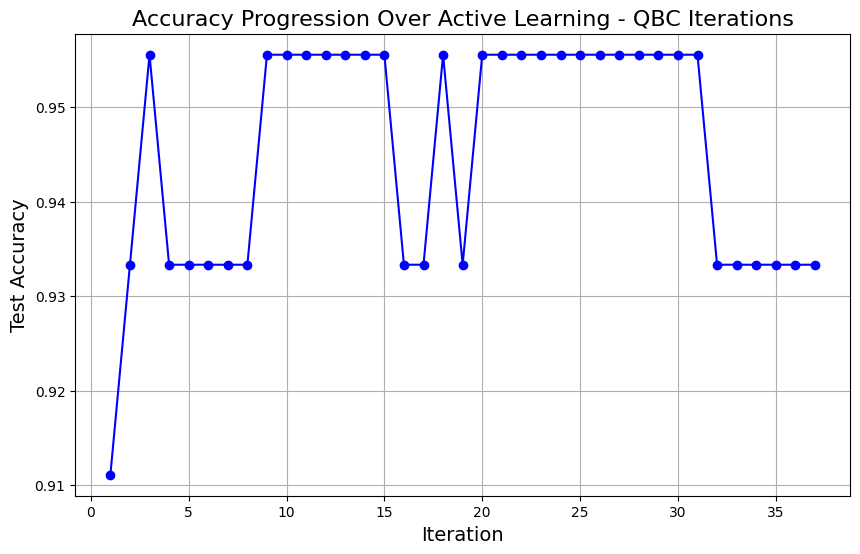

In [53]:
# Run active learning
accuracy_history = Active_Learning_qbc(
    X_labeled, y_labeled, X_unlabeled, y_unlabeled, X_test, y_test
)

# Plot accuracy progression
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-', color='b')
plt.title('Accuracy Progression Over Active Learning - QBC Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.grid(True)
plt.show()

## Accuracy Progression Over Active Learning - QBC Iterations

The plot illustrates the progression of test accuracy over iterations of active learning using the **Query-by-Committee (QBC)** strategy. This technique involves querying the most uncertain samples from an unlabeled pool to improve the model's performance iteratively.

### **Analysis**

1. **Initial Performance**:
   - At iteration 0, the test accuracy starts at approximately **0.91**. This baseline accuracy reflects the performance of the model trained on the initial labeled dataset.

2. **Fluctuations and Improvements**:
   - The test accuracy exhibits significant fluctuations throughout the iterations.
   - There are notable spikes in accuracy, such as around iterations 5, 10, and 20, where the accuracy reaches close to **0.96**.
   - These spikes indicate that querying certain samples significantly improves the model's generalization ability.
   - In fact, for any unlabeled sample, their were no decrease of the accuracy beyond **0.91**


3. **Stabilization**:
   - After iteration 25, the test accuracy stabilizes around **0.93**, with minimal fluctuations.
   - This stabilization indicates that the model has converged to a reasonably good performance level, and further queries are less likely to provide substantial improvements.




# Part 4 :  **📊 Analysis & Questions**

#### **Accuracy Improvements**

1. **Query-by-Committee (QBC)**:
   - **Initial Performance**: The model starts with a test accuracy of **0.91** at iteration 0, indicating a strong baseline performance.
   - **Fluctuations and Improvements**: Significant spikes in accuracy occur at iterations 5, 10, and 20, reaching close to **0.96**. These spikes demonstrate that querying uncertain samples can lead to substantial improvements in model performance.
   - **Stabilization**: After iteration 25, the accuracy stabilizes around **0.93**, indicating that the model has converged and further queries provide diminishing returns.

2. **Uncertainty Sampling**:
   - **Initial Performance**: The model starts with a lower test accuracy of **~0.89** at iteration 0, which increases to **0.91** by iteration 2. This suggests that the initial queried samples were representative and improved the model.
   - **Fluctuations**: The accuracy fluctuates significantly, with peaks (e.g., **0.96** at iteration 10) and troughs. These fluctuations indicate that uncertainty sampling occasionally queries less informative or noisy samples, which can degrade performance temporarily.
   - **Stabilization**: After iteration 25, the accuracy stabilizes around **0.93**, similar to QBC, suggesting that both methods eventually converge to a similar performance level.

---

#### **Query Efficiency**

1. **QBC**:
   - QBC demonstrates **consistent improvements** in accuracy with fewer fluctuations compared to uncertainty sampling. This suggests that the committee-based approach is more robust in selecting informative samples.
   - The stabilization of accuracy after iteration 25 indicates that QBC efficiently identifies the most informative samples early in the process.

2. **Uncertainty Sampling**:
   - Uncertainty sampling shows **higher variability** in accuracy, with significant peaks and troughs. This indicates that the method is less consistent in selecting informative samples.

---

#### **Model Stability**

1. **QBC**:
   - QBC exhibits **greater stability** in accuracy progression, with fewer and smaller fluctuations. This suggests that the committee-based approach is more reliable in maintaining consistent performance.
   - The stabilization phase is smoother, indicating that the model is less sensitive to noisy or less informative samples.

2. **Uncertainty Sampling**:
   - Uncertainty sampling shows **less stability**, with significant fluctuations in accuracy. This indicates that the model is more sensitive to the quality of the queried samples.
   - While the method eventually stabilizes, the path to convergence is less smooth compared to QBC.

---

## **Conclusion**

In conclusion, **QBC outperforms uncertainty sampling** in terms of query efficiency and model stability, while both methods achieve comparable final accuracy. However, the choice of method may depend on the specific application and the trade-off between stability and computational complexity.